# Stable Diffusion Deployment on Amazon SageMaker Endpoint

## Download Model Weights Ahead

### Prerequisite

0. Prepare a disk space no less than 60 GB. Consider Amazon Elastic File System (EFS) https://aws.amazon.com/efs/.
1. Install `git-lfs` per description at: https://git-lfs.github.com/
2. Create a HuggingFace account if haven't already at: https://huggingface.co/
3. Navigate to HuggingFace repository model card at: https://huggingface.co/runwayml/stable-diffusion-v1-5 and Agree to Accept the terms and conditions.
4. Navigate to HuggingFace repository model card at: https://huggingface.co/runwayml/stable-diffusion-inpainting and Agree to Accept the terms and conditions.
5. Create a Amazon S3 bucket

### Clone HuggingFace Stable Diffusion Text-to-Image and Image-to-Image Repository

```bash
# on Amazon EFS 
mkdir diffusion && cd diffusion
git lfs install --skip-smudge
git clone https://huggingface.co/runwayml/stable-diffusion-v1-5 && cd stable-diffusion-v1-5
git lfs pull
rm -rf .git
rm -rf. gitattributes
cd ..
```

### Clone HuggingFace Stable Diffusion Inpainting Repository

```bash
git clone https://huggingface.co/runwayml/stable-diffusion-inpainting
cd stable-diffusion-inpainting
git lfs pull
git lfs install --force
rm -rf .git
rm -rf. gitattributes
cd ..
```

## Local Test
1. Create a Virtual Environment for Python and activate it. Consider using Anaconda: https://www.anaconda.com/
2. Make Sure CUDA is available

In [1]:
import sys

sys.path.insert(0, "..")

path = "/home/ubuntu/efs/diffusion/stable-diffusion-v1-5/"
path_inpaint = "/home/ubuntu/efs/diffusion/stable-diffusion-inpainting/"

In [ ]:
!pip install -r ../image2image/code/requirements.txt

### Text to Image

In [3]:
from text2image.code.inference import *

t2i_pipe = model_fn(path)
data = {
    "prompt": "Australia, a beautiful country",
    "number": 3,
    "num_inference_steps": 50,
}
results = predict_fn(data, t2i_pipe)

  0%|          | 0/51 [00:00<?, ?it/s]

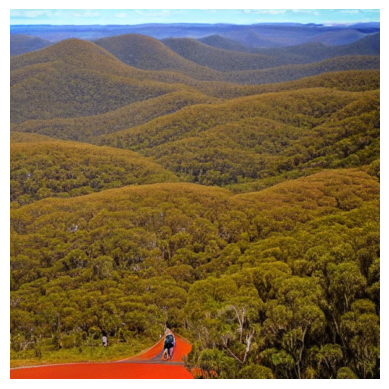

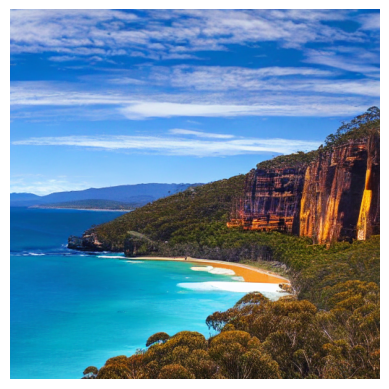

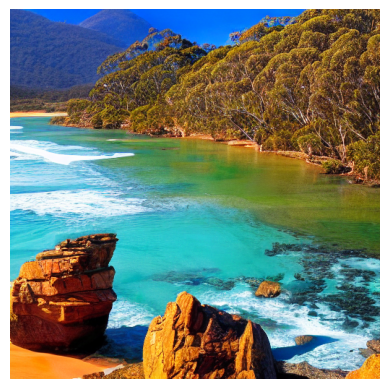

In [7]:
import matplotlib.pyplot as plt

for img_encoded in results["images"]:
    pred_decoded_byte = base64.decodebytes(bytes(img_encoded, encoding="utf-8"))
    pred_decoded = np.reshape(
        np.frombuffer(pred_decoded_byte, dtype=np.uint8), (512, 512, 3)
    )

    plt.imshow(pred_decoded)
    plt.axis("off")
    plt.show()

### Image to Image

May need to restart Jupyter Kernel to free GPU

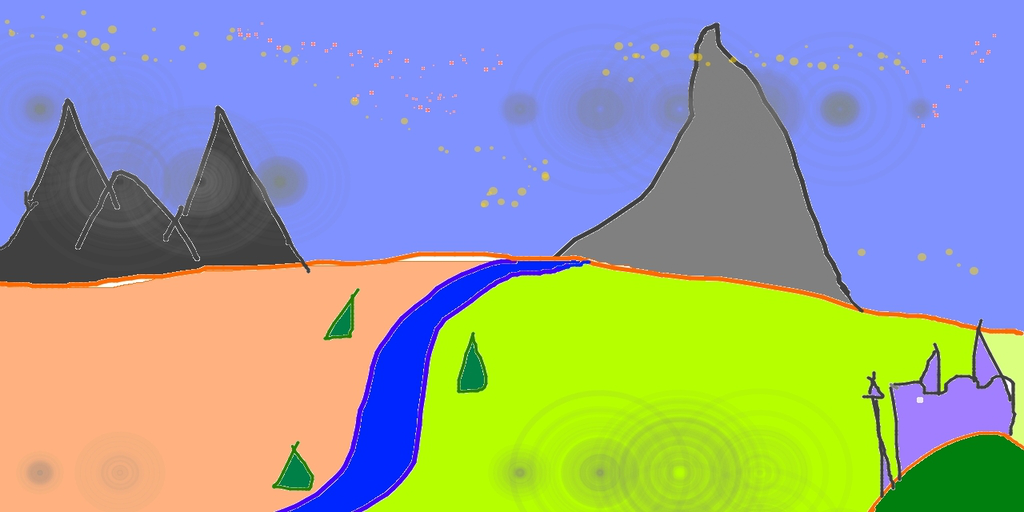

In [2]:
from image2image.code.inference import *

init_image = Image.open("../sample_img/sketch-mountains-input.jpg").convert("RGB")
init_image

In [3]:
i2i_pipe = model_fn(path)
data = {
    "prompt": "A fantasy landscape, trending on artstation",
    "init_image": base64.b64encode(np.array(init_image).astype(np.uint8)).decode(
        "utf-8"
    ),
    "height": init_image.size[1],
    "width": init_image.size[0],
    "number": 3,
    "num_inference_steps": 50,
}

results = predict_fn(data, i2i_pipe)

  0%|          | 0/38 [00:00<?, ?it/s]

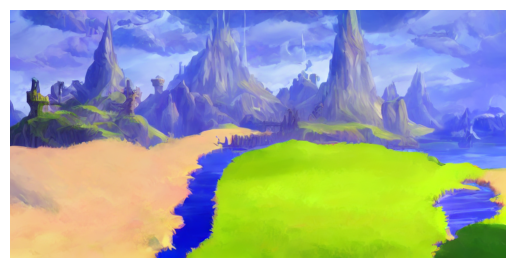

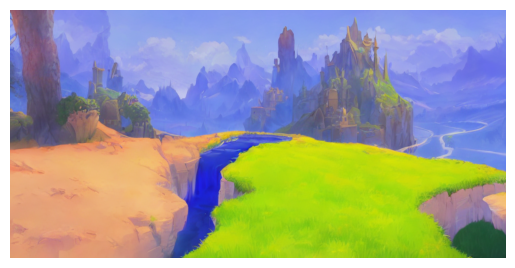

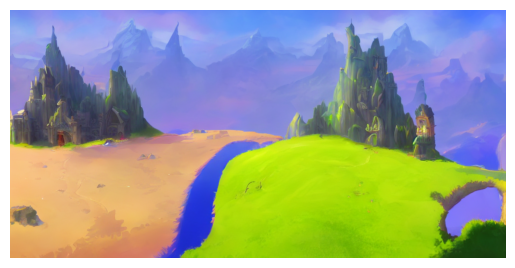

In [7]:
import matplotlib.pyplot as plt

for img_encoded in results["images"]:
    pred_decoded_byte = base64.decodebytes(bytes(img_encoded, encoding="utf-8"))
    pred_decoded = np.reshape(
        np.frombuffer(pred_decoded_byte, dtype=np.uint8),
        (results["height"], results["width"], 3),
    )

    plt.imshow(pred_decoded)
    plt.axis("off")
    plt.show()

### Inpainting

May need to restart Jupyter Kernel to free GPU

In [6]:
from inpainting.code.inference import *

init_image = Image.open("../sample_img/overture-creations-5sI6fQgYIuo.png").convert(
    "RGB"
)
mask_image = Image.open(
    "../sample_img/overture-creations-5sI6fQgYIuo_mask.png"
).convert("RGB")

data = {
    "prompt": "a cute cat lying on a park bench",
    "image": base64.b64encode(np.array(init_image).astype(np.uint8)).decode("utf-8"),
    "mask_image": base64.b64encode(np.array(mask_image).astype(np.uint8)).decode(
        "utf-8"
    ),
    "height": init_image.size[1],
    "width": init_image.size[0],
    "num_inference_steps": 50,
}

In [ ]:
inp_pipe = model_fn(path_inpaint)
results = predict_fn(data, inp_pipe)

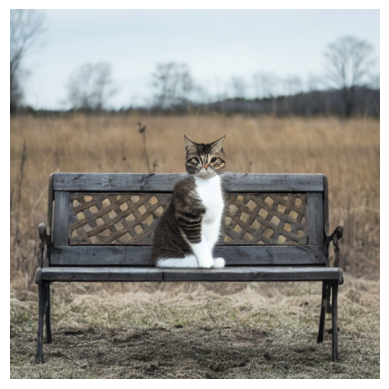

In [5]:
import matplotlib.pyplot as plt

for img_encoded in results["images"]:
    pred_decoded_byte = base64.decodebytes(bytes(img_encoded, encoding="utf-8"))
    pred_decoded = np.reshape(
        np.frombuffer(pred_decoded_byte, dtype=np.uint8),
        (results["height"], results["width"], 3),
    )

    plt.imshow(pred_decoded)
    plt.axis("off")
    plt.show()

## Deployment & Inference 

### Boilerplate

In [1]:
# !pip install boto3
# !pip install sagemaker


Note: make sure the IAM role has:

    AmazonS3FullAccess
    AmazonEC2ContainerRegistryFullAccess
    AmazonSageMakerFullAccess

Also make sure there is sufficient quota of Amazon SageMaker Endpoint instance type of your choice in your AWS Account, e.g. `ml.g4dn.xlarge`


In [2]:
import sagemaker
import boto3

sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket = None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client("iam")
    role = iam.get_role(RoleName="sagemaker_execution_role")["Role"]["Arn"]

sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

sagemaker role arn: arn:aws:iam::571744842822:role/EC2EFS
sagemaker bucket: sagemaker-us-west-2-571744842822
sagemaker session region: us-west-2


In [6]:
S3_BUCKET = "diffusion-deployment"  # change to your own S3 bucket name
MODEL_ID_TEXT2IMAGE = "stable-diffusion-text-to-image"
MODEL_ID_IMAGE2IMAGE = "stable-diffusion-image-to-image"
MODEL_ID_INPAINT = "stable-diffusion-inpainting"

s3_location_t2i = f"s3://{S3_BUCKET}/custom_inference/{MODEL_ID_TEXT2IMAGE}/model.tar.gz"
s3_location_i2i = f"s3://{S3_BUCKET}/custom_inference/{MODEL_ID_IMAGE2IMAGE}/model.tar.gz"
s3_location_inpaint = (
    f"s3://{S3_BUCKET}/custom_inference/{MODEL_ID_INPAINT}/model.tar.gz"
)
s3_location_t2i, s3_location_i2i, s3_location_inpaint

('s3://diffusion-deployment/custom_inference/stable-diffusion-text-to-image/model.tar.gz',
 's3://diffusion-deployment/custom_inference/stable-diffusion-image-to-image/model.tar.gz',
 's3://diffusion-deployment/custom_inference/stable-diffusion-inpainting/model.tar.gz')

In [8]:
from sagemaker.huggingface.model import HuggingFaceModel

def deploy_huggingface_sagemaker(model_s3_location, role):
    # create Hugging Face Model Class
    huggingface_model = HuggingFaceModel(
        model_data=model_s3_location,  # path to your model and script
        role=role,  # iam role with permissions to create an Endpoint
        transformers_version="4.17",  # transformers version used
        pytorch_version="1.10",  # pytorch version used
        py_version="py38",  # python version used
    )

    # deploy the endpoint endpoint
    predictor = huggingface_model.deploy(
        initial_instance_count=1, instance_type="ml.g4dn.xlarge"
    )
    return predictor.endpoint_name

### Text-to-Image

Compress Stable Diffusion Directory with `/code/inference.py` and `/code/requirements.txt`, then upload to s3.

In [ ]:
%%bash -s "$s3_location_t2i" "$path"
cp -r ../text2image/code/ $2
cd $2 && tar zcvf model.tar.gz * && aws s3 cp model.tar.gz $1

In [33]:
deploy_huggingface_sagemaker(s3_location_t2i, role)

-------------------!

'huggingface-pytorch-inference-2022-10-31-03-46-47-427'

#### Invoke the Endpoint via Boto3 SageMaker Client

In [52]:
content_type = "application/json"
request_body = {
    "prompt": "ancient chinese garden, overlooking full moon, ethereal colors, trending on artstation",
    "number": 3,
    "num_inference_steps": 50,
}

# Serialize data for endpoint
payload = json.dumps(request_body)

client = boto3.client("sagemaker-runtime")
response = client.invoke_endpoint(
    # change to your endpoint name returned in the previous step
    EndpointName="huggingface-pytorch-inference-2022-10-31-03-46-47-427",
    ContentType="application/json",
    Body=payload,
)
res = response["Body"].read()

#### Visualise the Generated Image

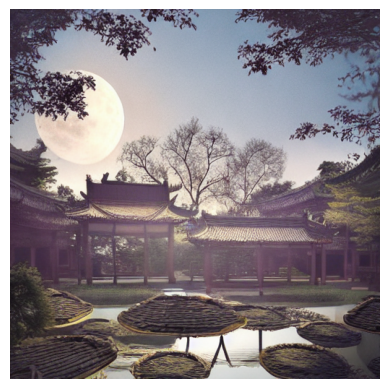

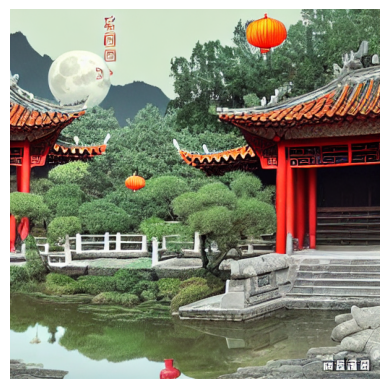

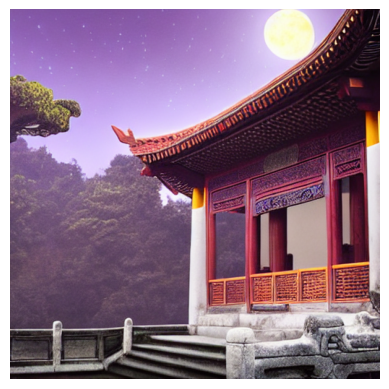

In [53]:
import matplotlib.pyplot as plt
import base64
import numpy as np

for img_encoded in eval(res)["images"]:
    pred_decoded_byte = base64.decodebytes(
        bytes(img_encoded, encoding="utf-8")
    )
    pred_decoded = np.reshape(np.frombuffer(pred_decoded_byte, dtype=np.uint8), (512, 512, 3))

    plt.imshow(pred_decoded)
    plt.axis("off")
    plt.show()

### Image-to-Image

In [47]:
path = "/home/ubuntu/efs/diffusion/stable-diffusion-v1-5/"

In [ ]:
%%bash -s "$s3_location_i2i" "$path"
cp -r ../image2image/code/ $2
cd $2 && tar zcvf model.tar.gz * 
aws s3 cp model.tar.gz $1

In [51]:
deploy_huggingface_sagemaker(s3_location_i2i, role)

--------------------!

'huggingface-pytorch-inference-2022-10-31-04-36-59-470'

In [69]:
from PIL import Image

init_image = Image.open("../sample_img/sketch-mountains-input.jpg").convert("RGB")

content_type = "application/json"
request_body = {
    "prompt": "A fantasy landscape, trending on artstation",
    "init_image": base64.b64encode(np.array(init_image).astype(np.uint8)).decode(
        "utf-8"
    ),
    "height": init_image.size[1],
    "width": init_image.size[0],
    "number": 2,
    "num_inference_steps": 40,
}

# Serialize data for endpoint
payload = json.dumps(request_body)

client = boto3.client("sagemaker-runtime")
response = client.invoke_endpoint(
    # change to your endpoint name returned in the previous step
    EndpointName="huggingface-pytorch-inference-2022-10-31-04-36-59-470",
    ContentType="application/json",
    Body=payload,
)
res = response["Body"].read()


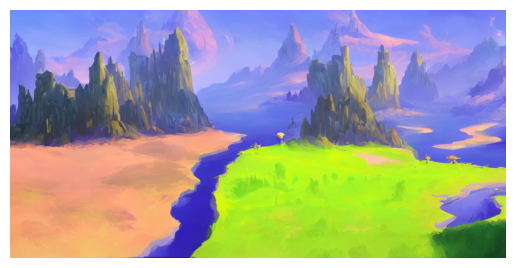

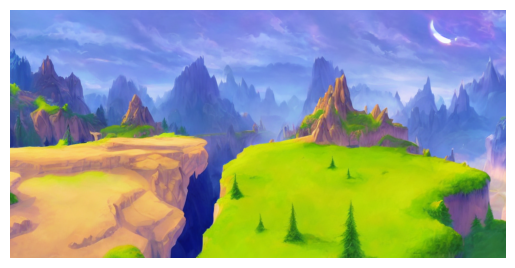

In [70]:
import matplotlib.pyplot as plt
import base64
import numpy as np

for img_encoded in eval(res)["images"]:
    pred_decoded_byte = base64.decodebytes(bytes(img_encoded, encoding="utf-8"))
    pred_decoded = np.reshape(
        np.frombuffer(pred_decoded_byte, dtype=np.uint8),
        (eval(res)["height"], eval(res)["width"], 3),
    )

    plt.imshow(pred_decoded)
    plt.axis("off")
    plt.show()

### inpainting

In [74]:
path_inpaint = "/home/ubuntu/efs/diffusion/stable-diffusion-inpainting/"

In [ ]:
%%bash -s "$s3_location_inpaint" "$path_inpaint"
cp -r ../inpainting/code/ $2
cd $2 && tar zcvf model.tar.gz *  && aws s3 cp model.tar.gz $1

In [77]:
deploy_huggingface_sagemaker(s3_location_inpaint, role)

------------!

'huggingface-pytorch-inference-2022-10-31-05-26-57-343'

In [78]:
from PIL import Image

init_image = Image.open("../sample_img/overture-creations-5sI6fQgYIuo.png").convert(
    "RGB"
)
mask_image = Image.open(
    "../sample_img/overture-creations-5sI6fQgYIuo_mask.png"
).convert("RGB")

request_body = {
    "prompt": "a cute cat lying on a park bench",
    "image": base64.b64encode(np.array(init_image).astype(np.uint8)).decode("utf-8"),
    "mask_image": base64.b64encode(np.array(mask_image).astype(np.uint8)).decode(
        "utf-8"
    ),
    "height": init_image.size[1],
    "width": init_image.size[0],
    "num_inference_steps": 50,
}

# Serialize data for endpoint
payload = json.dumps(request_body)

client = boto3.client("sagemaker-runtime")
response = client.invoke_endpoint(
    # change to your endpoint name returned in the previous step
    EndpointName="huggingface-pytorch-inference-2022-10-31-05-26-57-343",
    ContentType="application/json",
    Body=payload,
)
res = response["Body"].read()

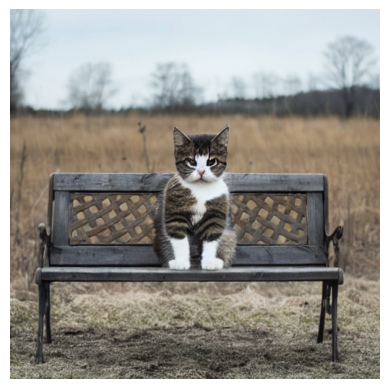

In [79]:
import matplotlib.pyplot as plt
import base64
import numpy as np

for img_encoded in eval(res)["images"]:
    pred_decoded_byte = base64.decodebytes(bytes(img_encoded, encoding="utf-8"))
    pred_decoded = np.reshape(
        np.frombuffer(pred_decoded_byte, dtype=np.uint8),
        (eval(res)["height"], eval(res)["width"], 3),
    )

    plt.imshow(pred_decoded)
    plt.axis("off")
    plt.show()

## Clean up

Make sure that you delete the following resources to prevent any additional charges:

- Amazon SageMaker endpoint.
- Amazon SageMaker endpoint configuration.
- Amazon SageMaker model.
- Amazon S3 buckets.

## Reference

1. https://github.com/huggingface/diffusers
2. https://github.com/aws-samples/amazon-sagemaker-image-based-transformers-examples
3. https://huggingface.co/docs/sagemaker/inference#deploy-a-transformers-model-trained-in-sagemaker
4. https://huggingface.co/blog/deploy-hugging-face-models-easily-with-amazon-sagemaker
5. https://github.com/huggingface/notebooks/blob/main/sagemaker/10_deploy_model_from_s3/deploy_transformer_model_from_s3.ipynb